# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [10]:
import matplotlib.pyplot as plt
import cv2  # нужно поставить себе cv2 через conda install opencv
from sklearn.cluster import KMeans
import numpy as np

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image)  # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

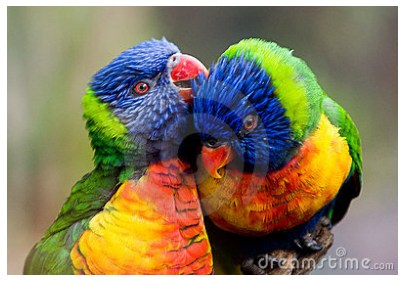

In [5]:
img = cv2.imread('birds.jpg')  # считать картинку
draw_picture(img)  # нарисовать картинку

In [39]:
print(img.shape)  # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [40]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

width, height, a = img.shape
res_im = img.reshape(width * height, 3)
arr = np.array([2, 3, 10, 20])
scores_list = []

for n in arr:
    kmeans = KMeans(n_clusters=n).fit(res_im)
    labels = kmeans.predict(res_im)
    identified_palette = np.array(kmeans.cluster_centers_).astype(int)
    new_img = np.copy(res_im)

    for index in range(len(new_img)):
        new_img[index] = identified_palette[labels[index]]

    new_img = new_img.reshape(width, height, 3)
    score = ssim(img, new_img, multichannel=True)
    scores_list.append((n, score))

best_k, best_score = max(scores_list, key=lambda x: x[1])
scores_list = np.array(scores_list)

print(f'{best_score} при K: {best_k}')


0.7593336377772659 при K: 20


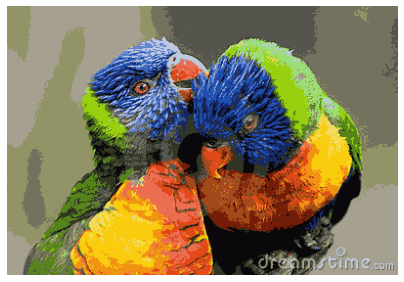

In [41]:
kmeans = KMeans(n_clusters=20, random_state=42).fit(res_im)
labels = kmeans.predict(res_im)

identified_palette = np.array(kmeans.cluster_centers_).astype(int)

new_img = np.copy(res_im)
for index in range(len(new_img)):
    new_img[index] = identified_palette[labels[index]]

new_img = new_img.reshape(width, height, 3)
draw_picture(new_img)


In [42]:
from sklearn.cluster import DBSCAN

eps = np.arange(1, 20, 2)
samples = np.arange(20, 40, 5)
scores_list = []

for e in eps:
    for n_samples in samples:
        dbscan = DBSCAN(eps=e, min_samples=n_samples).fit(res_im)
        labels = dbscan.fit_predict(res_im)
        identified_palette = np.array(dbscan.components_).astype(int)
        new_img = np.copy(res_im)
        for index in range(len(new_img)):
            new_img[index] = identified_palette[labels[index]]
        new_img = new_img.reshape(width, height, 3)
        scores_list.append((e, n_samples, ssim(img, new_img, multichannel=True)))

best_eps, best_n, best_score = max(scores_list, key=lambda x: x[2])

print(f'Лучшие параметры: eps: {best_eps}, samples: {best_n} , score: {best_score}')


Лучшие параметры: eps: 9, samples: 35 , score: 0.4162628261576407


Получилось сильно хуже, чем с KMeans.

In [43]:
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import AgglomerativeClustering

img1 = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
w1, h1, a = img1.shape
reshaped = img1.reshape(w1 * h1, 3)
arr = np.array([2, 3, 10, 20])
scores_list = []

for n in arr:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n, compute_distances=True).fit(reshaped)
    labels = agglomerative_clustering.fit_predict(reshaped)
    clf = NearestCentroid()
    clf.fit(reshaped, labels)
    identified_palette = np.array(clf.centroids_).astype(int)
    new_img = np.copy(reshaped)
    for index in range(len(new_img)):
        new_img[index] = identified_palette[labels[index]]
    new_img = new_img.reshape(w1, h1, 3)
    scores_list.append((n, ssim(img1, new_img, multichannel=True)))

best_k, best_score = max(scores_list, key=lambda x: x[1])
scores_list = np.array(scores_list)

print(f'Лучший score: {best_score} при K={best_k}')

Лучший score: 0.7381817563159867 при K=20


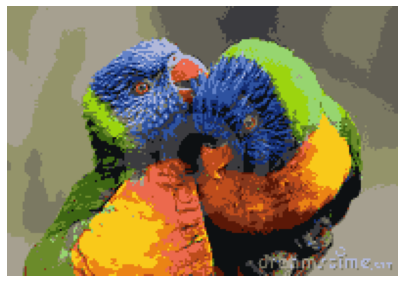

In [44]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=20, compute_distances=True).fit(reshaped)
labels = agglomerative_clustering.fit_predict(reshaped)
clf = NearestCentroid()
clf.fit(reshaped, labels)
identified_palette = np.array(clf.centroids_).astype(int)
new_img = np.copy(reshaped)
for index in range(len(new_img)):
    new_img[index] = identified_palette[labels[index]]
new_img = new_img.reshape(w1, h1, 3)
draw_picture(new_img)

Лучше всех справились KMeans и Агломеративная кластеризация, а DBSCAN справился так себе.

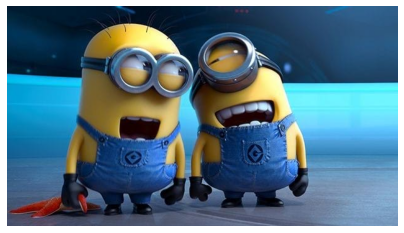

In [45]:
img2 = cv2.imread('minion.jpg')  # считать картинку
draw_picture(img2)  # нарисовать картинку

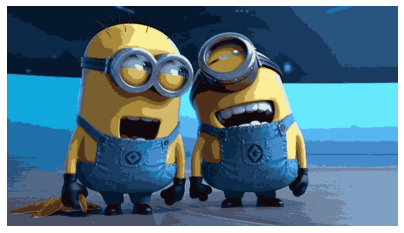

In [46]:
width, height, _ = img2.shape
res_im = img2.reshape(width * height, 3)

kmeans = KMeans(n_clusters=20, random_state=42).fit(res_im)
labels = kmeans.predict(res_im)

identified_palette = np.array(kmeans.cluster_centers_).astype(int)

new_img2 = np.copy(res_im)
for index in range(len(new_img2)):
    new_img2[index] = identified_palette[labels[index]]

new_img3 = new_img2.reshape(width, height, 3)
draw_picture(new_img3)


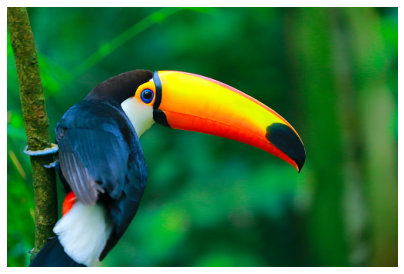

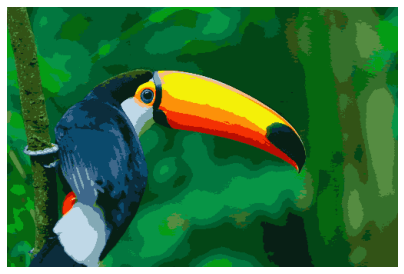

In [13]:
img3 = cv2.imread('newbird.jpg')  # считать картинку
draw_picture(img3)  # нарисовать картинку


width, height, _ = img3.shape
res_im = img3.reshape(width * height, 3)

kmeans = KMeans(n_clusters=20, random_state=42).fit(res_im)
labels = kmeans.predict(res_im)

identified_palette = np.array(kmeans.cluster_centers_).astype(int)

new_img3 = np.copy(res_im)
for index in range(len(new_img3)):
    new_img3[index] = identified_palette[labels[index]]

new_img3 = new_img3.reshape(width, height, 3)
draw_picture(new_img3)


Получилось неплохо, особенно первая картинка.

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [10]:
import warnings

warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [11]:
from sklearn.model_selection import train_test_split

X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [13]:
X.shape  # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [14]:
y.shape

(2370,)

In [15]:
names[8]  # в y лежат номера, а names переводит номер в имя

'George W Bush'

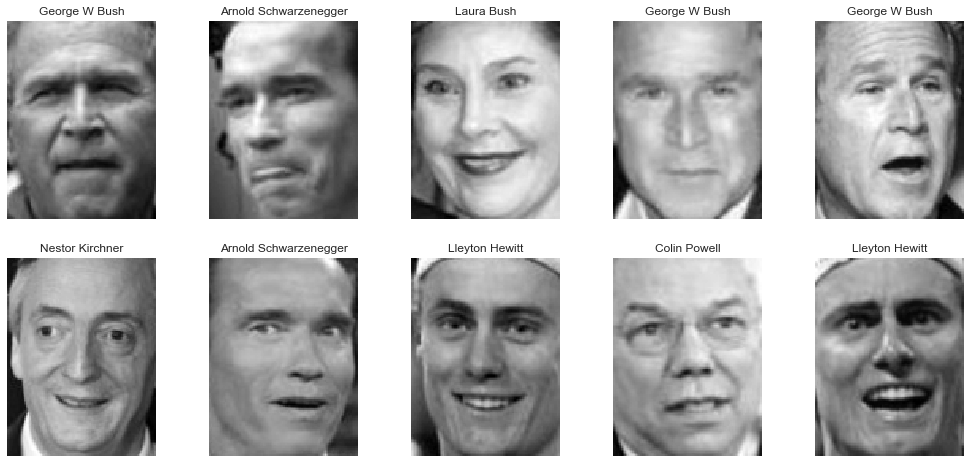

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')


def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')


plot_grid(range(10), nrows=2, ncols=5)  # первые 10 лиц

In [17]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

const_model = (np.ones(y_test.shape[0]) * 8).astype(int)
logistic_regression = linear_model.LogisticRegression(fit_intercept=True).fit(X_train, y_train)
forest_classifier = RandomForestClassifier().fit(X_train, y_train)


In [18]:
from sklearn.metrics import accuracy_score

print("Accuracy логистической регрессии \n", accuracy_score(y_test, logistic_regression.predict(X_test)))
print("Accuracy случайного леса \n", accuracy_score(y_test, forest_classifier.predict(X_test)))
print("Accuracy константной модели \n", accuracy_score(y_test, const_model))

Accuracy логистической регрессии 
 0.689873417721519
Accuracy случайного леса 
 0.4936708860759494
Accuracy константной модели 
 0.23839662447257384


Логрег справился лучше всех. Попробуем использовать PCA, думаю, его будет достаточно.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

pca = PCA()
X_pca_train = pca.fit(X_train).transform(X_train)
X_pca_test = pca.fit(X_train).transform(X_test)
log = LogisticRegression()
log.fit(X_pca_train, y_train)
y_pred = log.predict(X_pca_test)
accuracy_score(y_test, y_pred)

0.7109704641350211

Получилось неплохо

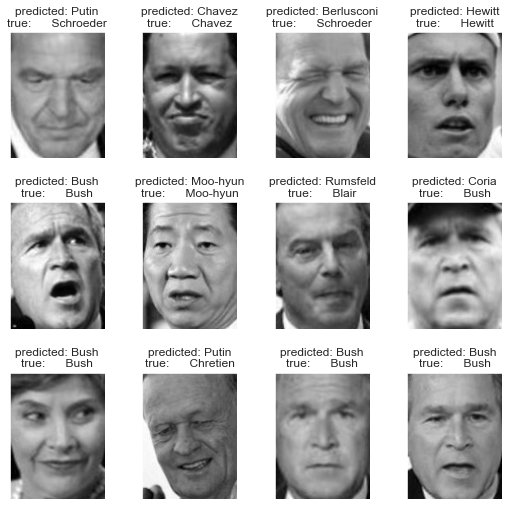

In [24]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, 125, 94)

Теперь изобразим датасет с помощью хорошо рисующего tSNE, он по идее неплохо подойдет для визуализации

Text(0.5, 1.0, 'tSNE')

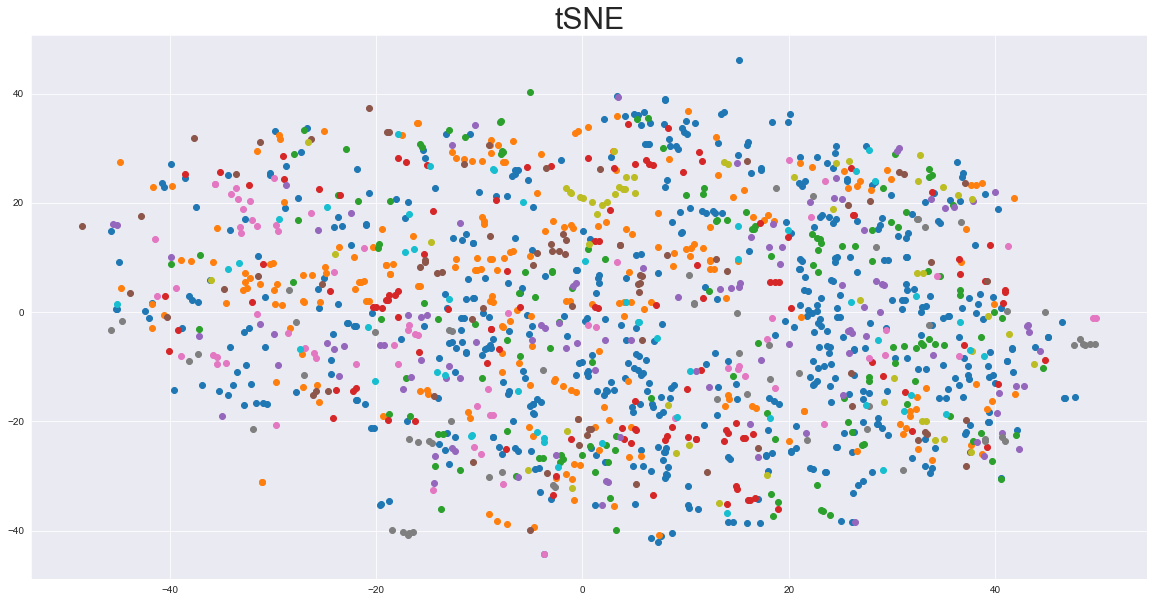

In [35]:
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib.colors import Normalize

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(X)

plt.figure(figsize=(20, 10))
for i in pd.Series(y).value_counts().index[:10]:
    norm = Normalize(vmin=0, vmax=10)
    color = plt.cm.gist_ncar(norm(i))
    plt.scatter(tsne_x[:, 0][y == i],
                tsne_x[:, 1][y == i], label=names[y[i]])

plt.title(u"tSNE", fontsize=30)


Получилось плохо(

Text(0.5, 1.0, 'PCA')

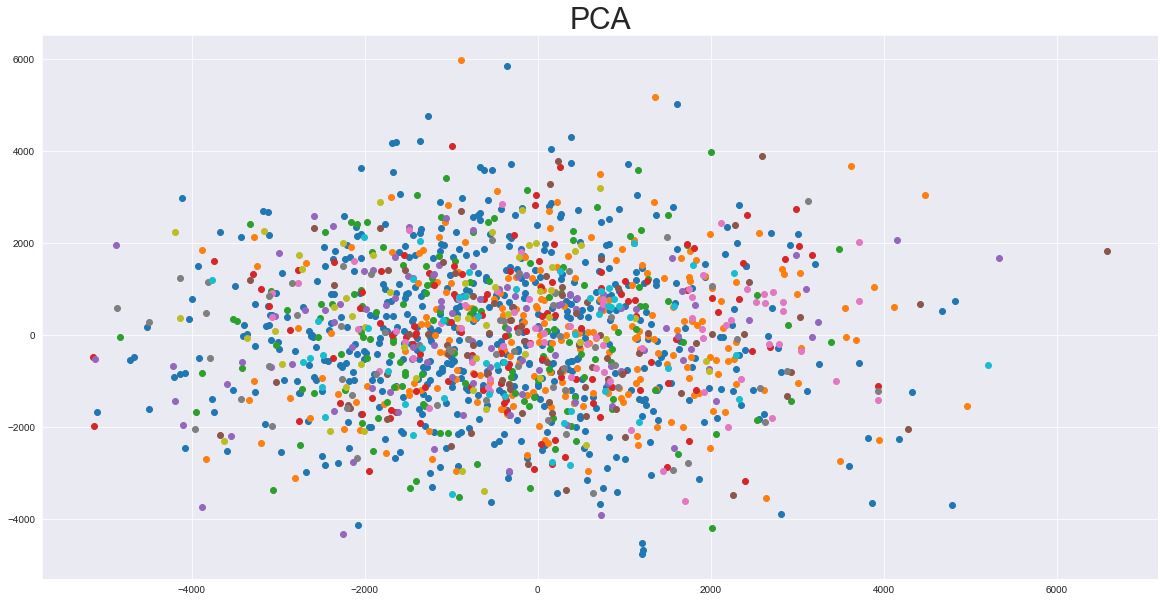

In [32]:
import pandas as pd
from matplotlib.colors import Normalize

pca = PCA(n_components=2)
PCA_X = pca.fit_transform(X)

plt.figure(figsize=(20, 10))
for i in pd.Series(y).value_counts().index[:10]:
    norm = Normalize(vmin=0, vmax=10)
    color = plt.cm.gist_ncar(norm(i))
    plt.scatter(PCA_X[:, 0][y == i],
                PCA_X[:, 1][y == i], label=names[y[i]])
plt.title(u"PCA", fontsize=30)

PCA тоже не помог, все еще фигово(